In [6]:
%load_ext autoreload
%autoreload 2


import pickle
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from scipy.spatial import Delaunay
import folium as f

from vars import DATASET
from utils import random_nodes, decode_polyline

g_pickle = "./data/01_" + DATASET + ".gpickle"
g = nx.read_gpickle(g_pickle)

node_ids = ['1132394795', '6008681316', '61370808', '4257848370', '1986708490', '64064094', '981460428', '7108530085', '4978546609', '2684107681', '519642929', '5912768531', '61317400', '61318535', '61324412', '61325844', '61170997', '5674432710', '620842047', '7762626866', '4865683882', '2487061247', '61561829', '1037989319', '61364203']

central_square = '61317423'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
random_nodes(g)

[{'lat': 42.3555982, 'lon': -71.1335312, 'id': '7641692199', 'tags': {}}]

In [31]:
[x for x in range(0, 10)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [32]:
node_names = {}

numbers = [x for x in range(11, 100)]
random_nums = random.sample(numbers, len(node_ids) + 1)

for idx, node in enumerate(node_ids):
    lat, lon = g.nodes()[node]['lat'], g.nodes()[node]['lon']
    node_names[(lat, lon)] = random_nums[idx]
    
# assign central square
node_names[(g.nodes()[central_square]['lat'], g.nodes()[central_square]['lon'])] = random_nums[-1]

In [33]:
import pickle
with open('./data/07_hardcoded_point_names.pkl', 'wb') as f:
    pickle.dump(node_names, f)

# Use triangulation to create subgraph

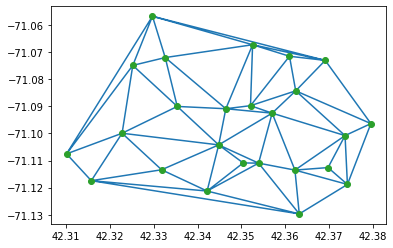

In [8]:
points = []
for node in node_ids:
    node = g.nodes()[node]
    lat, lon = node['lat'], node['lon']
    points.append([lat, lon])

points = np.array(points)
tri = Delaunay(points)

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

In [9]:
def edges_from_simplex(tri):
    edges = [] 
    points = tri.points
    for simplex in tri.simplices:
        a = points[(simplex[0])].tolist()
        b = points[simplex[1]].tolist()
        c = points[simplex[2]].tolist()
        edges.append([a,b])
        edges.append([b,c])
        edges.append([c,a])
    
    return_edges = []
    for edge in edges:
        if edge not in return_edges and [edge[1], edge[0]] not in return_edges:
            return_edges.append(edge)
    return return_edges

edges = edges_from_simplex(tri)

edges

[[[42.3252094, -71.0749335], [42.3297015, -71.0568123]],
 [[42.3297015, -71.0568123], [42.310066, -71.107549]],
 [[42.310066, -71.107549], [42.3252094, -71.0749335]],
 [[42.3525933, -71.0673168], [42.369192, -71.0730914]],
 [[42.369192, -71.0730914], [42.3297015, -71.0568123]],
 [[42.3297015, -71.0568123], [42.3525933, -71.0673168]],
 [[42.3227638, -71.0999462], [42.3252094, -71.0749335]],
 [[42.310066, -71.107549], [42.3227638, -71.0999462]],
 [[42.3737246, -71.1008111], [42.3742679, -71.1188142]],
 [[42.3742679, -71.1188142], [42.379635, -71.096387]],
 [[42.379635, -71.096387], [42.3737246, -71.1008111]],
 [[42.3539609, -71.1109653], [42.342193, -71.1212516]],
 [[42.342193, -71.1212516], [42.3632611, -71.1296873]],
 [[42.3632611, -71.1296873], [42.3539609, -71.1109653]],
 [[42.3252094, -71.0749335], [42.3326217, -71.0720415]],
 [[42.3326217, -71.0720415], [42.3297015, -71.0568123]],
 [[42.3326217, -71.0720415], [42.3525933, -71.0673168]],
 [[42.3326217, -71.0720415], [42.3464752, -71

In [10]:
def node_id_from_latlon(latlon):
    lat,lon = latlon
    for node in g.nodes().data():
        if node[1]['lat'] == lat and node[1]['lon'] == lon:
            return (node[0])

In [11]:
walks = []

for edge1 in edges:
    for edge2 in edges:
        if edge1 == edge2: 
            continue
        elif edge1[0] == edge2[0]:
            walks.append({"walk": [edge1, edge2],
                          "source": edge1[1],
                          "inter": [edge2[0]],
                          "dest": edge2[1]})
        elif edge1[0] == edge2[1]:
            walks.append({"walk": [edge1, edge2],
                          "source": edge1[1],
                          "inter": [edge2[1]],
                          "dest": edge2[0]})
        elif edge1[1] == edge2[0]:
            walks.append({"walk": [edge1, edge2],
                           "source": edge1[0],
                           "inter": edge2[0],
                           "dest": edge2[1]})
        elif edge1[1] == edge2[1]:
            walks.append({"walk": [edge1, edge2],
                          "source": edge1[0],
                          "inter": [edge2[1]],
                          "dest": edge2[0]})

In [12]:
def node_id_from_latlon(latlon):
    lat,lon = latlon
    for node in g.nodes().data():
        if node[1]['lat'] == lat and node[1]['lon'] == lon:
            return (node[0])
        
def dist_by_edge(edge): 
    a,b = edge
    lat_a,lon_a = a
    lat_b,lon_b = b
    a_id = node_id_from_latlon(a)
    b_id = node_id_from_latlon(b)
    try: 
        return nx.shortest_path_length(g, source=a_id, target=b_id, weight='havlen')
    except:
        return None


In [13]:
edges_to_eliminate = []

# The lower this number (between 0 and 1), the more lines eliminated
ELIMINATION_CUTOFF = .8


count = 0

for walk in walks:
    count+=1
    if count % 13 == 0: print( str(count) + " / " + str(len(walks)))
    
    BAD_DATA = False
    straight_distance = dist_by_edge((walk.get('source'), walk.get('dest')))
    if straight_distance is None: 
        BAD_DATA = True
        continue
    roundabout_distance = 0
    for edge in walk.get('walk'):  
        edge_dist = dist_by_edge(edge)
        if edge_dist is None: 
            BAD_DATA = True
            continue
        roundabout_distance += dist_by_edge(edge)
    if BAD_DATA: continue
    if (roundabout_distance * ELIMINATION_CUTOFF < straight_distance):
        edges_to_eliminate.append((node_id_from_latlon(walk.get('source')), node_id_from_latlon(walk.get('dest'))))

13 / 578
26 / 578
39 / 578
52 / 578
65 / 578
78 / 578
91 / 578
104 / 578
117 / 578
130 / 578
143 / 578
156 / 578
169 / 578
182 / 578
195 / 578
208 / 578
221 / 578
234 / 578
247 / 578
260 / 578
273 / 578
286 / 578
299 / 578
312 / 578
325 / 578
338 / 578
351 / 578
364 / 578
377 / 578
390 / 578
403 / 578
416 / 578
429 / 578
442 / 578
455 / 578
468 / 578
481 / 578
494 / 578
507 / 578
520 / 578
533 / 578
546 / 578
559 / 578
572 / 578


In [14]:
final_edges = []

for edge in edges:
    is_eliminated = False
    
    source, dest = edge
    source_id = node_id_from_latlon(source)
    dest_id = node_id_from_latlon(dest)
    for edge_to_elim in edges_to_eliminate:
        if (source_id, dest_id) == edge_to_elim:
            is_eliminated = True
            continue
    if not is_eliminated:
        final_edges.append(edge)
        
print ((str (len(edges) - len(final_edges))) + " lines removed out of " + str(len(edges)) + ". Too few? Too many? Change ELIMINATION_CUTOFF.")

16 lines removed out of 65. Too few? Too many? Change ELIMINATION_CUTOFF.


# Map of subgraph. If you don't like what you see, change ELIMINATION_CUTOFF

In [15]:
def shortest_path_by_edge(edge): 
    a,b = edge
    lat_a,lon_a = a
    lat_b,lon_b = b
    a_id = node_id_from_latlon(a)
    b_id = node_id_from_latlon(b)
    try: 
        return nx.shortest_path(g, source=a_id, target=b_id, weight='havlen')
    except:
        return None


m = f.Map(location = [42.3611108,-71.119977], zoom_start=14)
for final_edge in final_edges:
    short_path_edges = shortest_path_by_edge(final_edge)
    if short_path_edges is None: continue
    
    line_locations = [[g.nodes()[n_id]['lat'], g.nodes()[n_id]['lon']] for n_id in short_path_edges]
    m.add_child(f.PolyLine(locations=line_locations, line_opacity=1, color="green"))

display_nums = {}
num = 50
for node_id in node_ids:
    num += 1
    display_nums[node_id] = num

for node_data in g.nodes().data():
    node_id = node_data[1]["id"]
    lon,lat = node_data[1]['lon'], node_data[1]['lat'] 
    
    if node_id in node_ids:
        size = 25
        display_num = 4
#         m.add_child(f.CircleMarker(location=[lat,lon], color="blue", radius=2, tooltip=node_id))
        f.Marker(location=[lat,lon],
                  # Set icon to DivIcon to with conditional style formatting to reference the random temp value.
                  icon=f.DivIcon(html=f"""<div style="border:1px solid green; text-align: center; vertical-align: middle; line-height: {size}px; background-color: white; width: {size}px; height: {size}px; border-radius: {size}px; font-family: sans-serif; color: green;">{display_nums[node_id]}</div>""")
                 ).add_to(m)
m

# Export Final Edges

In [16]:
import pickle
with open('./data/07' + DATASET + '_no_central_square_final_edges.pkl', 'wb') as f:
    pickle.dump(final_edges, f)